In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import tarfile


In [52]:
# os.makedirs("celeba_gan")

# url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
# output = "celeba_gan/data.zip"
# gdown.download(url, output, quiet=True)

# with ZipFile("celeba_gan/data.zip", "r") as zipobj:
#     zipobj.extractall("celeba_gan")

In [53]:
dataset = keras.preprocessing.image_dataset_from_directory("../data", 
                                                            label_mode=None, 
                                                            image_size=(128, 128), 
                                                            batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 1 classes.


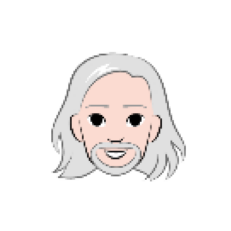

In [54]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


In [55]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128,128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)           

In [56]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 64, 64, 512)       20

In [57]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [58]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
                self.num_img = num_img
                self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


In [59]:
epochs = 10  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy())

# gan.fit(
#     dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
# )


In [67]:
from pprint import pprint
model_path = "../saved_weights/generator.h5"

model = keras.models.load_model(model_path)

latent_dim = 128 
n_samples = 32

x_input = np.random.randn(n_samples,latent_dim) 

pprint(x_input.shape)

img_pred = model.predict(x_input)
img_pred

    # ValueError: Input 0 of layer generator is incompatible with the layer: expected axis -1 of input shape to have value 128 but received input with shape (32, 64, 64, 3)

(32, 128)


array([[[[0.98372954, 0.9625988 , 0.96582603],
         [0.9976547 , 0.98399967, 0.9664022 ],
         [0.99798733, 0.99016726, 0.982156  ],
         ...,
         [0.98731726, 0.95129657, 0.93489975],
         [0.9857858 , 0.97117525, 0.9544076 ],
         [0.9755338 , 0.94836   , 0.9181662 ]],

        [[0.98619896, 0.9892506 , 0.983496  ],
         [0.9939129 , 0.98253405, 0.97910786],
         [0.9829035 , 0.9964319 , 0.99033546],
         ...,
         [0.9562897 , 0.93695676, 0.9083695 ],
         [0.9597734 , 0.9514863 , 0.89543664],
         [0.99810183, 0.99315095, 0.98333436]],

        [[0.99969155, 0.99734396, 0.99755687],
         [0.9987687 , 0.99358314, 0.9943443 ],
         [0.995384  , 0.99031675, 0.98684955],
         ...,
         [0.9357049 , 0.92803323, 0.8743285 ],
         [0.91536486, 0.8834115 , 0.8236873 ],
         [0.99781424, 0.99468875, 0.9812083 ]],

        ...,

        [[0.99978876, 0.99890924, 0.99786085],
         [0.9953568 , 0.99731106, 0.99565226]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

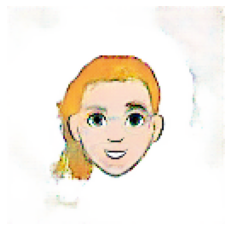

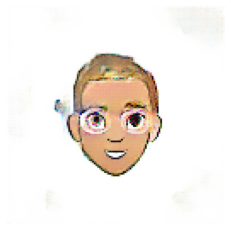

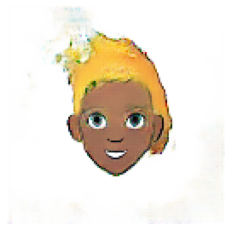

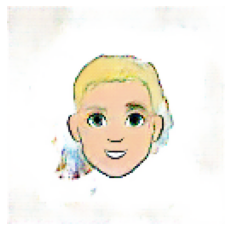

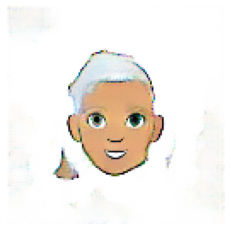

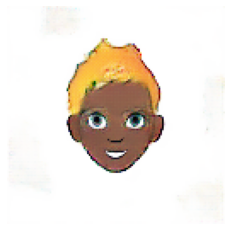

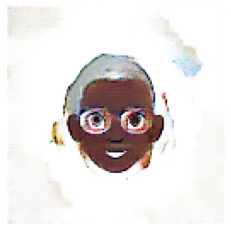

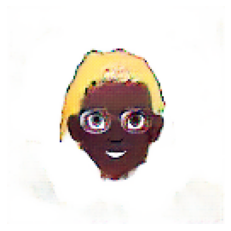

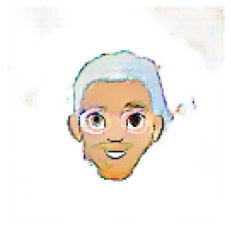

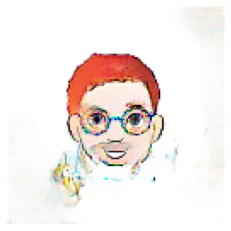

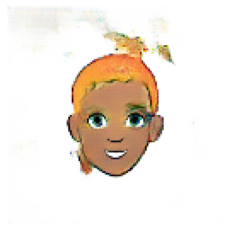

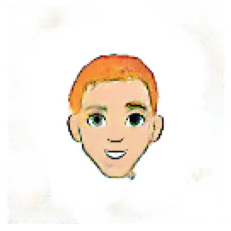

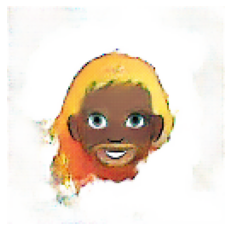

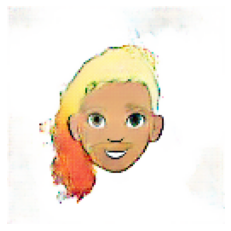

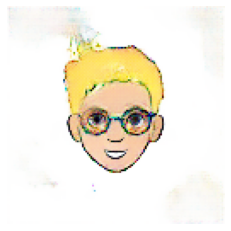

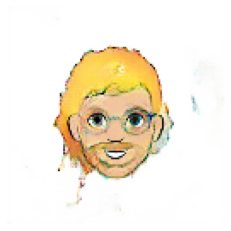

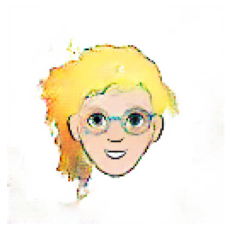

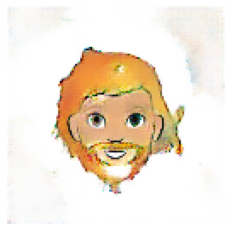

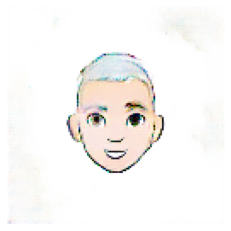

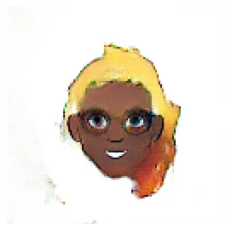

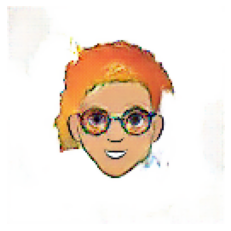

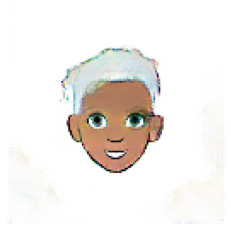

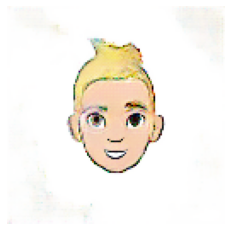

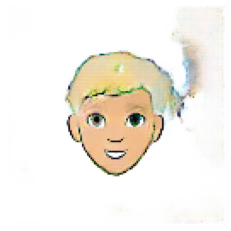

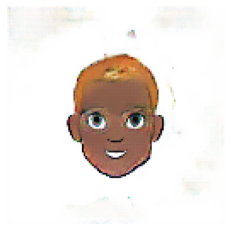

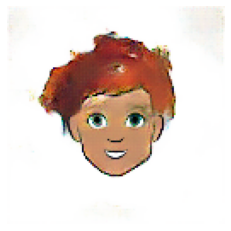

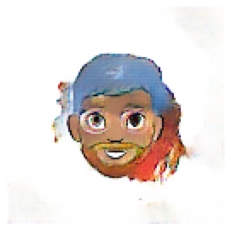

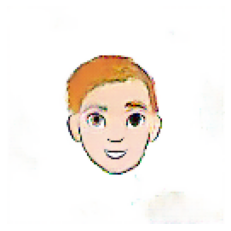

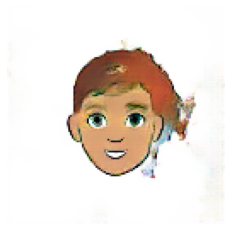

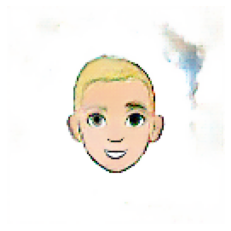

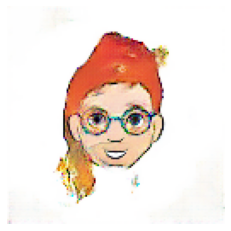

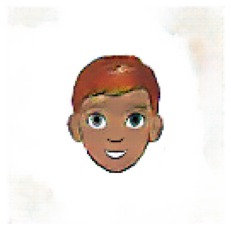

In [81]:
for x in img_pred : 
    plt.figure()
    plt.axis("off")
    plt.imshow((x*255).astype("int32"))

In [ ]:
for x in image1 : 
    plt.figure()
    plt.axis("off")
    plt.imshow((x*255).astype("int32"))